In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

print("Enter the stocks (example-AAPL AMZN JPM PG JNJ):")
user_input = input()
assets = user_input.split()
years_input = input("Data of how many years is to be used? ")
time_period = years_input + "y"
df = yf.download(assets, period=time_period)['Close']

Enter the stocks (example-AAPL AMZN JPM PG JNJ):


In [ ]:
returns_df = df.fillna(method="ffill").pct_change().dropna()

expected_return = returns_df.mean().values * 252
cov_matrix = returns_df.cov().values * 252
n = len(assets)

lambdas = np.logspace(-2, 3, 40)

frontier_returns = []
frontier_risks = []
weights_list = []

w = cp.Variable(n)

for L in lambdas:
    risk = cp.quad_form(w, cov_matrix)
    objective = cp.Maximize(expected_return @ w - (L / 2) * risk)
    constraints = [cp.sum(w) == 1, w >= 0]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    if prob.status == "optimal":
        weights_list.append(w.value)
        frontier_returns.append(expected_return @ w.value)
        portfolio_variance = w.value.T @ cov_matrix @ w.value
        frontier_risks.append(np.sqrt(portfolio_variance))

weights_df = pd.DataFrame(weights_list, index=lambdas, columns=assets)

/tmp/ipython-input-4063291077.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns_df = df.fillna(method="ffill").pct_change().dropna()


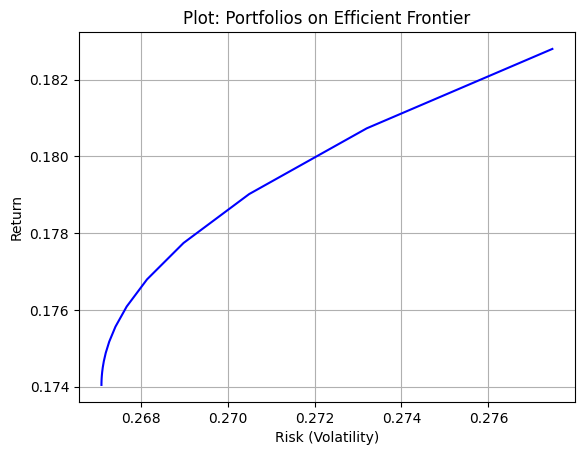

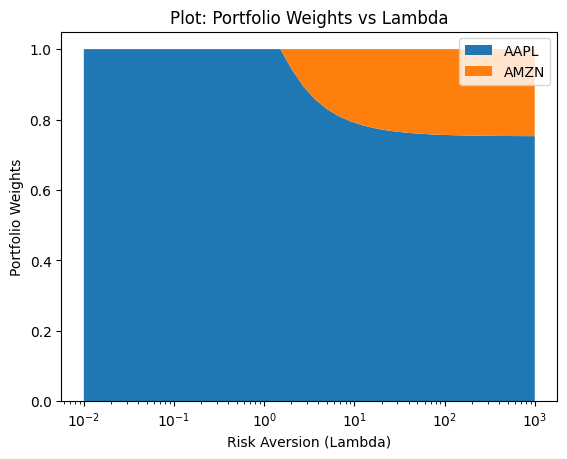

In [ ]:
plt.figure()
plt.plot(frontier_risks, frontier_returns, color='blue')
plt.title('Plot: Portfolios on Efficient Frontier')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Return')
plt.grid(True)
plt.show()

plt.figure()
plt.stackplot(lambdas, weights_df.T, labels=assets)
plt.xscale('log')
plt.title('Plot: Portfolio Weights vs Lambda')
plt.xlabel('Risk Aversion (Lambda)')
plt.ylabel('Portfolio Weights')
plt.legend(loc='upper right')
plt.show()